# Data Analytics Project
- Project Name: Revenue VatVisual
- Team Name: Best TeamName = None
- Team Member: Qifu Yin, Yue Zheng, Fengfan Yang, Xuchen Qiu

# Catboost  Machine Learning

### Part I: Data Preprocessing
Generally speaking, there are three steps in this part: 1. We fill Nan values with 0s or empty strings depend on the datatypes of the columns. 2. We calculate and add some other useful indicators. 3. We drop the columns with only one constant value and columns which acontain no consumers behavior information.


#### 1.Install and import libraries

In [2]:
!pip install catboost # install catboost 

Invalid requirement: '#'
Traceback (most recent call last):
  File "G:\Anaconda3\lib\site-packages\pip\_vendor\packaging\requirements.py", line 90, in __init__
    req = REQUIREMENT.parseString(requirement_string)
  File "G:\Anaconda3\lib\site-packages\pip\_vendor\pyparsing.py", line 1632, in parseString
    raise exc
  File "G:\Anaconda3\lib\site-packages\pip\_vendor\pyparsing.py", line 1622, in parseString
    loc, tokens = self._parse( instring, 0 )
  File "G:\Anaconda3\lib\site-packages\pip\_vendor\pyparsing.py", line 1379, in _parseNoCache
    loc,tokens = self.parseImpl( instring, preloc, doActions )
  File "G:\Anaconda3\lib\site-packages\pip\_vendor\pyparsing.py", line 3395, in parseImpl
    loc, exprtokens = e._parse( instring, loc, doActions )
  File "G:\Anaconda3\lib\site-packages\pip\_vendor\pyparsing.py", line 1379, in _parseNoCache
    loc,tokens = self.parseImpl( instring, preloc, doActions )
  File "G:\Anaconda3\lib\site-packages\pip\_vendor\pyparsing.py", line 3717, in 

In [162]:
import pandas as pd 
import numpy as np
import json
from pandas.io.json import json_normalize # to normalize json object
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
from catboost import CatBoostRegressor # CatBoostRegressor is used in regression to predict revenue
from sklearn.preprocessing import LabelEncoder #to transform non-numerical labels to numerical labels
from sklearn.model_selection import TimeSeriesSplit, KFold # provides train/test indices to split time series data samples in train/test sets.
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### 2. Read the data and extract multiple information to seperate columns
In our original file, some of the columns contain multiple subcolumns and are formated in JSON type. We define a function to flattern these subcolumns and attached then to dataframe.

For example, Json column 'device' may contains multiple information such as: browser, browsersize... We flattern these columns as device.browser, device.browsersize as subcolumns of the dataframe when we read the data.

In [163]:
#load the csv files,expand json format of columns
def load_df(csv_path, JSON_COLUMNS):

    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'})
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    return df

In [164]:
# read train dataset
df_train = load_df(csv_path='train.csv', JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource'])#be patient

In [165]:
# read test dataset
df_test = load_df(csv_path="test.csv",JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource'])

In [166]:
df_train_origin=df_train
df_test_origin=df_test

#### 3. Fill missing values

In [167]:
#fill na values with transactionRevenue
goal = df_train['totals.transactionRevenue'].fillna(0).astype(float)
goal = goal.apply(lambda x: np.log1p(x))#turns to log
del df_train['totals.transactionRevenue']

In [168]:
#if one column only has one value, consider to delete the column
columns_to_remove = [col for col in df_train.columns if df_train[col].nunique() == 1]

In [169]:
columns_to_remove

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.bounces',
 'totals.newVisits',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.campaignCode',
 'trafficSource.isTrueDirect']

In [170]:
#print out the columns(with unique value) that could be useful. E.g,If the columns has only one unique numeric value and nan values,we fill with 0 
for col in columns_to_remove:
    if df_train[col].unique().any()=='not available in demo dataset': 
        continue
    print(col, df_train[col].dtypes, df_train[col].unique())

socialEngagementType object ['Not Socially Engaged']
totals.bounces object ['1' nan]
totals.newVisits object ['1' nan]
totals.visits object ['1']
trafficSource.adwordsClickInfo.isVideoAd object [nan False]
trafficSource.campaignCode object [nan '11251kjhkvahf']
trafficSource.isTrueDirect object [nan True]


In [171]:
#fill the useful columns with values
df_train['trafficSource.adwordsClickInfo.isVideoAd'] = df_train['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True)
df_test['trafficSource.adwordsClickInfo.isVideoAd'] = df_test['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True)

df_train['trafficSource.isTrueDirect'] = df_train['trafficSource.isTrueDirect'].fillna(False)
df_test['trafficSource.isTrueDirect'] = df_test['trafficSource.isTrueDirect'].fillna(False)

df_train['totals.bounces'] = df_train['totals.bounces'].fillna('0')
df_test['totals.bounces'] = df_test['totals.bounces'].fillna('0')

df_train['totals.newVisits'] = df_train['totals.newVisits'].fillna('0')
df_test['totals.newVisits'] = df_test['totals.newVisits'].fillna('0')


In [172]:
#find the columns with multiple values
columns = [col for col in df_train.columns if df_train[col].nunique() > 1]

In [173]:
#slice the test and train dataframes
df_train = df_train[columns]
df_test = df_test[columns]

In [174]:
#concatenate train and test dataset together
train_len = df_train.shape[0]
df_merge= pd.concat([df_train, df_test])

#### 4. Data type transformation

In [175]:
#process date into details
from datetime import datetime
def date_process(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["weekday"] = df['date'].dt.weekday #extracting week day
    df["day"] = df['date'].dt.day # extracting day
    df["month"] = df['date'].dt.month # extracting day
    df["year"] = df['date'].dt.year # extracting day
    df['visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    
    return df

In [176]:
df_merge = date_process(df_merge)

In [177]:
#calculate the statistcs of mean hits per day and month 
df_merge['totals.hits'] = df_merge['totals.hits'].astype(int)
df_merge['mean_hits_per_day'] = df_merge.groupby(['day'])['totals.hits'].transform('mean')
df_merge['mean_hits_per_month'] = df_merge.groupby(['month'])['totals.hits'].transform('mean')

In [178]:
df_merge

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.medium,trafficSource.referralPath,trafficSource.source,weekday,day,month,year,visitHour,mean_hits_per_day,mean_hits_per_month
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,...,organic,NaN,google,4,2,9,2016,11,4.492082,4.677380
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,...,organic,NaN,google,4,2,9,2016,1,4.492082,4.677380
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,...,organic,NaN,google,4,2,9,2016,21,4.492082,4.677380
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,...,organic,NaN,google,4,2,9,2016,1,4.492082,4.677380
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,...,organic,NaN,google,4,2,9,2016,9,4.492082,4.677380
5,Organic Search,2016-09-02,2938943183656635653,2938943183656635653_1472807194,1472807194,1,1472807194,Chrome,desktop,False,...,organic,NaN,google,4,2,9,2016,5,4.492082,4.677380
6,Organic Search,2016-09-02,1905672039242460897,1905672039242460897_1472817241,1472817241,1,1472817241,Chrome,desktop,False,...,organic,NaN,google,4,2,9,2016,7,4.492082,4.677380
7,Organic Search,2016-09-02,537222803633850821,537222803633850821_1472812602,1472812602,1,1472812602,Chrome,desktop,False,...,organic,NaN,google,4,2,9,2016,6,4.492082,4.677380
8,Organic Search,2016-09-02,4445454811831400414,4445454811831400414_1472805784,1472805784,1,1472805784,Internet Explorer,desktop,False,...,organic,NaN,google,4,2,9,2016,4,4.492082,4.677380
9,Organic Search,2016-09-02,9499785259412240342,9499785259412240342_1472812272,1472812272,1,1472812272,Firefox,desktop,False,...,organic,NaN,google,4,2,9,2016,6,4.492082,4.677380


In [179]:
df_merge=df_merge.fillna('')

In [180]:
#label encoding for distinctive categorical values
#we can skip this step if we define cat_features in our catboost model,but this encoding increase calculation speed and returns similar RMSE
#The time consumption is 2 minutes(with feature encoding) vs 30 minutes(no feature encoding)
#if you want to check the catboost model's functionality in directly dealing with categorical features,
#just comment out this block's code, and comment back the 'cat_features' parameter in the model we set up later in this notebook
for col in df_merge.columns:
    if col in ['fullVisitorId', 'month', 'day', 'year','weekday', 'visit_hour','date','visitStartTime','visitId','sessionId']: continue
    if df_merge[col].dtypes == object or df_merge[col].dtypes == bool:
        df_merge[col], indicators = pd.factorize(df_merge[col])

In [181]:
df_merge

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.medium,trafficSource.referralPath,trafficSource.source,weekday,day,month,year,visitHour,mean_hits_per_day,mean_hits_per_month
0,0,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,0,0,0,...,0,0,0,4,2,9,2016,11,4.492082,4.677380
1,0,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,1,0,0,...,0,0,0,4,2,9,2016,1,4.492082,4.677380
2,0,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,0,0,0,...,0,0,0,4,2,9,2016,21,4.492082,4.677380
3,0,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,2,0,0,...,0,0,0,4,2,9,2016,1,4.492082,4.677380
4,0,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,0,1,1,...,0,0,0,4,2,9,2016,9,4.492082,4.677380
5,0,2016-09-02,2938943183656635653,2938943183656635653_1472807194,1472807194,1,1472807194,0,0,0,...,0,0,0,4,2,9,2016,5,4.492082,4.677380
6,0,2016-09-02,1905672039242460897,1905672039242460897_1472817241,1472817241,1,1472817241,0,0,0,...,0,0,0,4,2,9,2016,7,4.492082,4.677380
7,0,2016-09-02,537222803633850821,537222803633850821_1472812602,1472812602,1,1472812602,0,0,0,...,0,0,0,4,2,9,2016,6,4.492082,4.677380
8,0,2016-09-02,4445454811831400414,4445454811831400414_1472805784,1472805784,1,1472805784,3,0,0,...,0,0,0,4,2,9,2016,4,4.492082,4.677380
9,0,2016-09-02,9499785259412240342,9499785259412240342_1472812272,1472812272,1,1472812272,1,0,0,...,0,0,0,4,2,9,2016,6,4.492082,4.677380


#### 5. Drop useless columns

In [182]:
#delte columns that we won't use
del df_merge['date']
#del df_merge['weekday']
del df_merge['year']
#del df_merge['visitHour']
#del df_merge['day']
#del df_merge['month']
del df_merge['visitStartTime']
del df_merge['visitId'] 
del df_merge['sessionId']

In [183]:
df_merge

,channelGrouping,fullVisitorId,visitNumber,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,...,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,weekday,day,month,visitHour,mean_hits_per_day,mean_hits_per_month
0,0,1131660440785968503,1,0,0,0,0,0,0,0,...,0,0,0,0,4,2,9,11,4.492082,4.677380
1,0,377306020877927890,1,1,0,0,1,1,1,1,...,0,0,0,0,4,2,9,1,4.492082,4.677380
2,0,3895546263509774583,1,0,0,0,0,2,2,2,...,0,0,0,0,4,2,9,21,4.492082,4.677380
3,0,4763447161404445595,1,2,0,0,2,1,0,3,...,1,0,0,0,4,2,9,1,4.492082,4.677380
4,0,27294437909732085,2,0,1,1,3,1,2,4,...,0,0,0,0,4,2,9,9,4.492082,4.677380
5,0,2938943183656635653,1,0,0,0,0,1,2,5,...,0,0,0,0,4,2,9,5,4.492082,4.677380
6,0,1905672039242460897,1,0,0,0,0,1,0,6,...,0,0,0,0,4,2,9,7,4.492082,4.677380
7,0,537222803633850821,1,0,0,0,0,3,1,1,...,0,0,0,0,4,2,9,6,4.492082,4.677380
8,0,4445454811831400414,1,3,0,0,0,1,2,7,...,0,0,0,0,4,2,9,4,4.492082,4.677380
9,0,9499785259412240342,1,1,0,0,0,1,2,8,...,0,0,0,0,4,2,9,6,4.492082,4.677380


#### 6. Deal with train and test dataset

In [184]:
#get back and set the train and test set
x_train = df_merge[:train_len]
x_test = df_merge[train_len:]

In [185]:
#also set the log revenue from train dataset as y_train
y_train=goal.to_frame()

In [186]:
y_train.rename(columns={'totals.transactionRevenue':'Revenue'}, inplace=True)

In [187]:
#drop of the fullVisitId
x_train = x_train.drop(['fullVisitorId'], axis=1)
x_test = x_test.drop(['fullVisitorId'], axis=1)

In [188]:
x_train.dtypes

channelGrouping                                   int64
visitNumber                                       int64
device.browser                                    int64
device.deviceCategory                             int64
device.isMobile                                   int64
device.operatingSystem                            int64
geoNetwork.city                                   int64
geoNetwork.continent                              int64
geoNetwork.country                                int64
geoNetwork.metro                                  int64
geoNetwork.networkDomain                          int64
geoNetwork.region                                 int64
geoNetwork.subContinent                           int64
totals.bounces                                    int64
totals.hits                                       int64
totals.newVisits                                  int64
totals.pageviews                                  int64
trafficSource.adContent                         

In [189]:
#split test and train set
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [190]:
print(f"Train shape: {X_train.shape}")
print(f"Test for Validation shape: {X_test.shape}")
print(f"Test (submit) shape: {x_test.shape}")

Train shape: (722922, 35)
Test for Validation shape: (180731, 35)
Test (submit) shape: (804684, 35)


### Part II: Machine Learning
We introduce our CatBoost library used in machine learning process. It is a newly invented library which was just published last year. It includes lots of advantages. 1. It can directly deal with categorical features so it is not necessary to do Label Encoding. 2. It is time efficient compared to other ML algorithms. 3. It is also robust and reduce the need for extensive hyper-parameter tuning.

#### 1. Model regression

In [191]:
#set up the catboost model and predict，tuning the parameters, some parameters have better default values, so we don't manually define them
model = CatBoostRegressor(
                          iterations=500, #max number of iterations
                             learning_rate=0.1, #learning step
                             depth=10, #decision tree depth
                             eval_metric='RMSE', #the method to measure the accuracy
                             #bagging_temperature = 0.2,
                             od_type='Iter',
                             od_wait=50)#check for over-fitting
#we can use cat_features,but the speed will much slower compared with feature encoding.
#cat_features indicate which columns are categorical feature. You can comment back to this functionality
model.fit(X_train, Y_train, #cat_features=[0,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28]
              eval_set=(X_test, Y_test),
              use_best_model=True,
              verbose=True)
    
pred_submit = model.predict(x_test)


0:	learn: 1.9591943	test: 1.9570423	best: 1.9570423 (0)	total: 436ms	remaining: 3m 37s
1:	learn: 1.9111098	test: 1.9082480	best: 1.9082480 (1)	total: 1.04s	remaining: 4m 19s
2:	learn: 1.8706200	test: 1.8679896	best: 1.8679896 (2)	total: 1.47s	remaining: 4m 3s
3:	learn: 1.8363465	test: 1.8328056	best: 1.8328056 (3)	total: 1.85s	remaining: 3m 49s
4:	learn: 1.8072274	test: 1.8029546	best: 1.8029546 (4)	total: 2.36s	remaining: 3m 53s
5:	learn: 1.7831851	test: 1.7789059	best: 1.7789059 (5)	total: 2.8s	remaining: 3m 50s
6:	learn: 1.7623414	test: 1.7577926	best: 1.7577926 (6)	total: 3.19s	remaining: 3m 44s
7:	learn: 1.7448175	test: 1.7399425	best: 1.7399425 (7)	total: 3.55s	remaining: 3m 38s
8:	learn: 1.7300792	test: 1.7251209	best: 1.7251209 (8)	total: 3.99s	remaining: 3m 37s
9:	learn: 1.7176791	test: 1.7128991	best: 1.7128991 (9)	total: 4.33s	remaining: 3m 32s
10:	learn: 1.7067098	test: 1.7024936	best: 1.7024936 (10)	total: 4.63s	remaining: 3m 25s
11:	learn: 1.6978275	test: 1.6939432	best: 

93:	learn: 1.5676108	test: 1.6214089	best: 1.6213246 (92)	total: 36s	remaining: 2m 35s
94:	learn: 1.5671170	test: 1.6215127	best: 1.6213246 (92)	total: 36.3s	remaining: 2m 34s
95:	learn: 1.5659493	test: 1.6213153	best: 1.6213153 (95)	total: 36.6s	remaining: 2m 33s
96:	learn: 1.5653614	test: 1.6211408	best: 1.6211408 (96)	total: 37s	remaining: 2m 33s
97:	learn: 1.5648165	test: 1.6210516	best: 1.6210516 (97)	total: 37.3s	remaining: 2m 32s
98:	learn: 1.5635070	test: 1.6209162	best: 1.6209162 (98)	total: 37.7s	remaining: 2m 32s
99:	learn: 1.5632236	test: 1.6209275	best: 1.6209162 (98)	total: 38.1s	remaining: 2m 32s
100:	learn: 1.5622311	test: 1.6207876	best: 1.6207876 (100)	total: 38.3s	remaining: 2m 31s
101:	learn: 1.5614914	test: 1.6209323	best: 1.6207876 (100)	total: 38.6s	remaining: 2m 30s
102:	learn: 1.5607575	test: 1.6205966	best: 1.6205966 (102)	total: 39.1s	remaining: 2m 30s
103:	learn: 1.5599136	test: 1.6204829	best: 1.6204829 (103)	total: 39.5s	remaining: 2m 30s
104:	learn: 1.559

184:	learn: 1.5032763	test: 1.6177017	best: 1.6172119 (180)	total: 1m 3s	remaining: 1m 47s
185:	learn: 1.5026345	test: 1.6176518	best: 1.6172119 (180)	total: 1m 3s	remaining: 1m 47s
186:	learn: 1.5021377	test: 1.6175738	best: 1.6172119 (180)	total: 1m 3s	remaining: 1m 46s
187:	learn: 1.5011081	test: 1.6174930	best: 1.6172119 (180)	total: 1m 4s	remaining: 1m 46s
188:	learn: 1.5003472	test: 1.6173626	best: 1.6172119 (180)	total: 1m 4s	remaining: 1m 45s
189:	learn: 1.5000592	test: 1.6173267	best: 1.6172119 (180)	total: 1m 4s	remaining: 1m 45s
190:	learn: 1.4997057	test: 1.6172179	best: 1.6172119 (180)	total: 1m 4s	remaining: 1m 45s
191:	learn: 1.4987117	test: 1.6173201	best: 1.6172119 (180)	total: 1m 5s	remaining: 1m 44s
192:	learn: 1.4976567	test: 1.6173548	best: 1.6172119 (180)	total: 1m 5s	remaining: 1m 44s
193:	learn: 1.4967613	test: 1.6173369	best: 1.6172119 (180)	total: 1m 5s	remaining: 1m 43s
194:	learn: 1.4962045	test: 1.6174241	best: 1.6172119 (180)	total: 1m 5s	remaining: 1m 43s

274:	learn: 1.4474008	test: 1.6159447	best: 1.6156672 (267)	total: 1m 29s	remaining: 1m 12s
275:	learn: 1.4470861	test: 1.6160208	best: 1.6156672 (267)	total: 1m 29s	remaining: 1m 12s
276:	learn: 1.4463824	test: 1.6160658	best: 1.6156672 (267)	total: 1m 29s	remaining: 1m 12s
277:	learn: 1.4458088	test: 1.6160911	best: 1.6156672 (267)	total: 1m 30s	remaining: 1m 12s
278:	learn: 1.4455728	test: 1.6161474	best: 1.6156672 (267)	total: 1m 30s	remaining: 1m 11s
279:	learn: 1.4451085	test: 1.6161356	best: 1.6156672 (267)	total: 1m 30s	remaining: 1m 11s
280:	learn: 1.4449708	test: 1.6160999	best: 1.6156672 (267)	total: 1m 31s	remaining: 1m 11s
281:	learn: 1.4439576	test: 1.6159121	best: 1.6156672 (267)	total: 1m 31s	remaining: 1m 10s
282:	learn: 1.4432685	test: 1.6159619	best: 1.6156672 (267)	total: 1m 32s	remaining: 1m 10s
283:	learn: 1.4427822	test: 1.6158646	best: 1.6156672 (267)	total: 1m 32s	remaining: 1m 10s
284:	learn: 1.4418361	test: 1.6159533	best: 1.6156672 (267)	total: 1m 32s	remain

In [192]:
#the predicted revenue
pred_submit

array([ 0.01185376,  0.01930036,  0.00647846, ...,  2.06223637,
       -1.65386408, -1.73191274])

#### 2. Feature importance analysis

In [193]:
#get importance feature score and plot them, the model has the method called 'get_feature_importance()'
feature_score = pd.DataFrame(list(zip(x_train.dtypes.index, model.get_feature_importance())),columns=['Feature','Score'])

In [194]:
feature_score=feature_score.sort_values(by=['Score'])

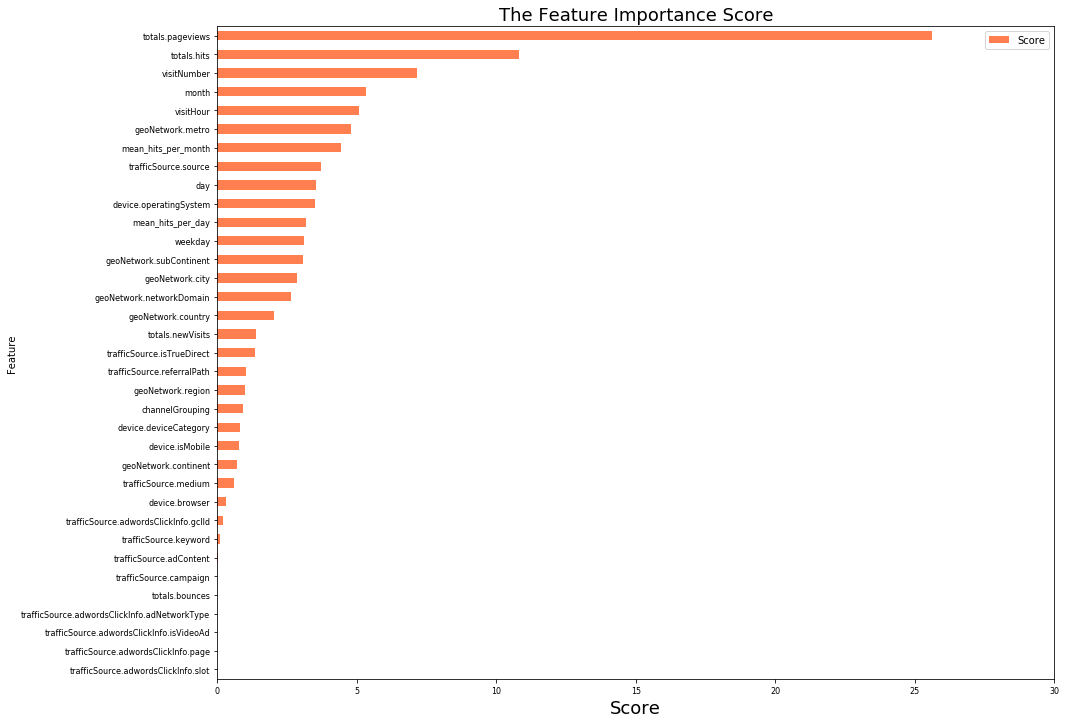

In [195]:
ax = feature_score.plot(y='Score', x='Feature',kind='barh', figsize=(15,12),
                                        color="coral", fontsize=8)
ax.set_alpha(0.8)
ax.set_title("The Feature Importance Score", fontsize=18)
ax.set_xlabel("Score", fontsize=18)
ax.set_xticks([0, 5, 10, 15, 20,25,30])


#### 3. Revenue prediction result and export

In [196]:
#some predicted value are negative, set them to 0
for i in range(len(pred_submit)): 
     if pred_submit[i]<0:
            pred_submit[i]=0

In [197]:
pred_submit

array([0.01185376, 0.01930036, 0.00647846, ..., 2.06223637, 0.        ,
       0.        ])

In [198]:
#export the results to csv files
final_result = df_test[['fullVisitorId']].copy()
final_result.loc[:, 'PredictedRevenue'] = pred_submit
toCSV = final_result[['fullVisitorId', 'PredictedRevenue']].groupby('fullVisitorId').sum().reset_index()
toCSV.to_csv('test_submit.csv',index=False)

In [199]:
df_test_origin.loc[:, 'PredictedRevenue'] = pred_submit

In [200]:
df_test_origin.to_csv('test_predicted.csv',index=False)#export the csv file with whole original test file and our predicted revenue

In [201]:
final_result

,fullVisitorId,PredictedRevenue
0,6167871330617112363,0.011854
1,0643697640977915618,0.019300
2,6059383810968229466,0.006478
3,2376720078563423631,0.000000
4,2314544520795440038,0.007392
5,4133039884103392367,0.025174
6,4320478850207397557,0.119431
7,5876438247590157131,0.923461
8,0514591268737702944,0.000000
9,6430567031531677212,0.019300
